# Explainer Notebook

## 1. Motivation

* What is your dataset?
* Why did you choose this/these particular dataset(s)?
* What was your goal for the end user's experience?

## 2. Basic stats. Let's understand the dataset better

* Write about your choices in data cleaning and preprocessing
* Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.

In [ ]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import folium
import os
import time
import seaborn as sns
sns.set()
from shapely.geometry import Point
import geopandas
from shapely import wkt

In this project, we are working with three main datasets:
1. A pre-processed dataset from OpenData [ref]
2. The original dataset from of the pre-processed dataset, containing the specific times that measurements were taken
3. A weather dataset from DMI.

### 2.1 The preprocessed dataset

Although we are working with a dataset that has already been preprocessed, we have to process it further, as we only need some of the columns and most column names are written in Danish. We start by looking at the columns and rows of the dataset:

In [ ]:
# Data preparation
df_tt = pd.read_csv('data/trafiktaelling.csv')
df_tt = df_tt.drop(['FID'], axis=1)

count_row = df_tt.shape[0]
count_col = df_tt.shape[1]

print(f'The dataset consists of {count_row} rows and {count_col} columns')

print('The columns are:')
df_tt.info(memory_usage="deep")

The dataset consists of 1077 rows and 35 columns
The columns are:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1077 entries, 0 to 1076
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   t_nr                1077 non-null   int64  
 1   vejnavn             1077 non-null   object 
 2   beskrivelse         923 non-null    object 
 3   husnummer           760 non-null    object 
 4   type                1076 non-null   float64
 5   taelling_type       1077 non-null   object 
 6   ktj_7_19            538 non-null    float64
 7   tung_pct            496 non-null    object 
 8   aadt_koretojer      538 non-null    float64
 9   hvdt_koretojer      538 non-null    float64
 10  cykler_7_19         605 non-null    float64
 11  ladcykler_pct       333 non-null    object 
 12  aadt_cykler         605 non-null    float64
 13  hvdt_cykler         605 non-null    float64
 14  fod_7_19            332 non-null    fl

The dates (`taelle_dato`) are transformed into datetime objects. Sometimes, datasets are not complete in terms of years, i.e. they do not always span an entire year. This could be the case of our dataset, so we inspect the number of observations for each year:

In [ ]:
# Transform into datetime
df_tt['date'] = pd.to_datetime(df_tt.taelle_dato, format="%Y%m%d")
df_tt['date'].dt.year.value_counts()

2015    182
2016    163
2019    162
2014    120
2018     89
2017     75
2013     68
2011     63
2012     60
2010     45
2009     44
2020      6
Name: date, dtype: int64

Since we only have 6 observations for 2020, which could be due to the Covid-19 lockdowns, we filter out values from 2020. 

By further inspection of the `wkb_geometry` column, we see that they are `POINT(...)` objects of the longitude and latitude of our observations, wrapped in a string. We convert them into geometry objects for us to extract the longitude and latitude.

In [ ]:
# Filter out values from 2020
df_tt = df_tt[df_tt.date.dt.year < 2020]

# Convert into geometry objects
df_tt['wkb_geometry'] = geopandas.GeoSeries.from_wkt(df_tt['wkb_geometry'])

# Remove nans
df_tt = df_tt[~df_tt.wkb_geometry.isna()]

# Extract lon and lat for plotting
df_tt['lon'] = df_tt.wkb_geometry.apply(lambda p: p.x)
df_tt['lat'] = df_tt.wkb_geometry.apply(lambda p: p.y)

We also remove unnecessary columns, so that we keep the following:

1. `t_nr`: a specific ID for the counting (will be used later)
2. `ktj_7_19`: number of cars
3. `cykler_7_19`: number of bikes
4. `fod_7_19`: number of pedestrians
5. `lastbiler_7_19`: number of trucks
6. `elloebehjul_7_19`: number of electric scooters
7. `date`: the date for which the measurements were taken
8. `lon`: the longitude coordinate for the measurement
9. `lat`: the latitude coordinate for the measurement

The columns are translated from Danish to English.

In [ ]:
cols_of_interest = ['t_nr', 'ktj_7_19', 'cykler_7_19', 'fod_7_19', 'lastbiler_7_19', 'elloebehjul_7_19', 
                    'date', 'lon', 'lat']
df_tt = df_tt[cols_of_interest]
# Rename columns
df_tt.rename(columns={
    "ktj_7_19": "cars", 
    "cykler_7_19": "bikes",
    "fod_7_19": "pedestrians",
    "lastbiler_7_19": "trucks",
    "elloebehjul_7_19": "electric scooters"}, inplace=True)

With our data now being preprocessed, we proceed by presenting the total counts for each of our observations, by year.

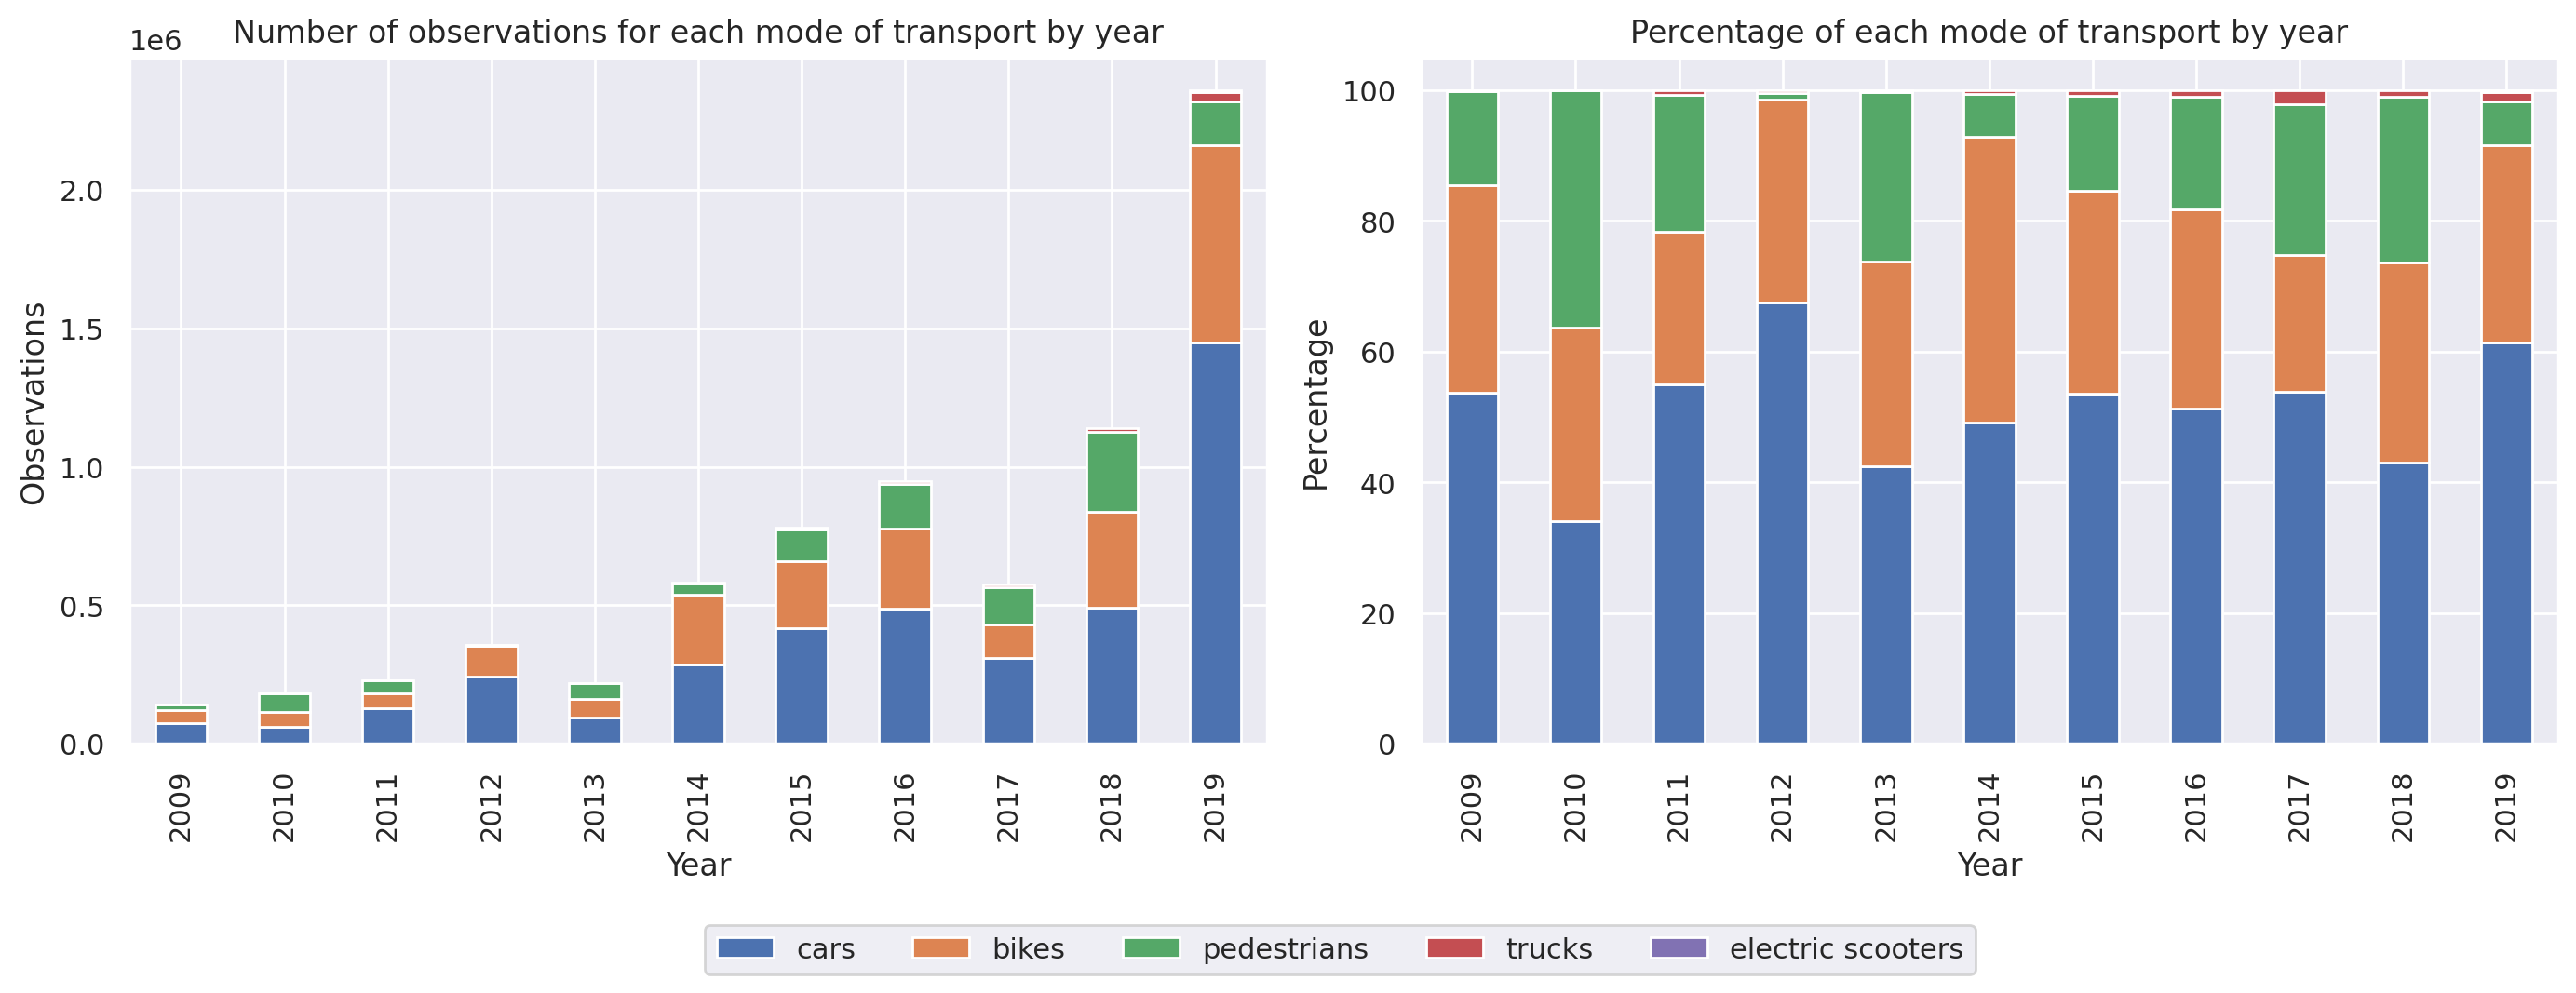

In [ ]:
modes_of_transport = ['cars', 'bikes', 'pedestrians', 'trucks', 'electric scooters']

df_tt['year'] = df_tt['date'].dt.year
df_year_count = df_tt[modes_of_transport+['year']].groupby('year').sum()

df_year_fraction = pd.DataFrame()
for i in range(len(modes_of_transport)):
    df_year_fraction[modes_of_transport[i]] = df_year_count[modes_of_transport[i]]/df_year_count.sum(axis=1)*100

fig, ax = plt.subplots(1, 2, figsize=(14,5), dpi=200)
p1 = df_year_count.plot.bar(stacked='True', ax=ax[0], 
                       title='Number of observations for each mode of transport by year',
                       xlabel='Year',
                       ylabel='Observations',
                       legend=0)

p2 = df_year_fraction.plot.bar(stacked='True', ax=ax[1], 
                       title='Percentage of each mode of transport by year',
                       xlabel='Year',
                       ylabel='Percentage',
                       legend=0)

plt.tight_layout()
plt.legend(loc='right', bbox_to_anchor=(0.5, -0.3), ncol=5)
plt.show()

## 3. Data Analysis

* Describe your data analysis and explain what you've learned about the dataset. 
* If relevant, talk about your machine-learning.

## 4. Genre.

* Which genre of data story did you use?
* Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?
* Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?


## 5. Visualizations.


* Explain the visualizations you've chosen.
* Why are they right for the story you want to tell?

## 6. Discussion. Think critically about your creation

* What went well?
* What is still missing? What could be improved? Why?

## Contributions. Who did what?

* You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That's what you should explain).
* It is not OK simply to write "All group members contributed equally".

In [ ]:
pd.DataFrame({'Mean': df_year_count.mean(), 'Median': df_year_count.median(), 'Standard Deviation': df_year_count.std()}).round(decimals=2)

,Mean,Median,Standard Deviation
Cars,367173.27,286021.0,392750.50
Bikes,208779.36,120048.0,198244.31
Pedestrians,99031.45,65641.0,83254.15
Trucks,7540.36,3310.0,10366.71
Electric Scooters,552.91,0.0,1833.79


In [ ]:
df_year_count.describe()

,Cars,Bikes,Pedestrians,Trucks,Electric Scooters
count,1.100000e+01,11.000000,11.000000,11.000000,11.000000
mean,3.671733e+05,208779.363636,99031.454545,7540.363636,552.909091
std,3.927505e+05,198244.311865,83254.146615,10366.711169,1833.791998
min,6.152500e+04,44587.000000,3570.000000,95.000000,0.000000
25%,1.097500e+05,61289.000000,43376.000000,1172.000000,0.000000
50%,2.860210e+05,120048.000000,65641.000000,3310.000000,0.000000
75%,4.521220e+05,271527.000000,145614.000000,10720.500000,0.000000
max,1.450512e+06,710159.000000,288656.000000,35603.000000,6082.000000


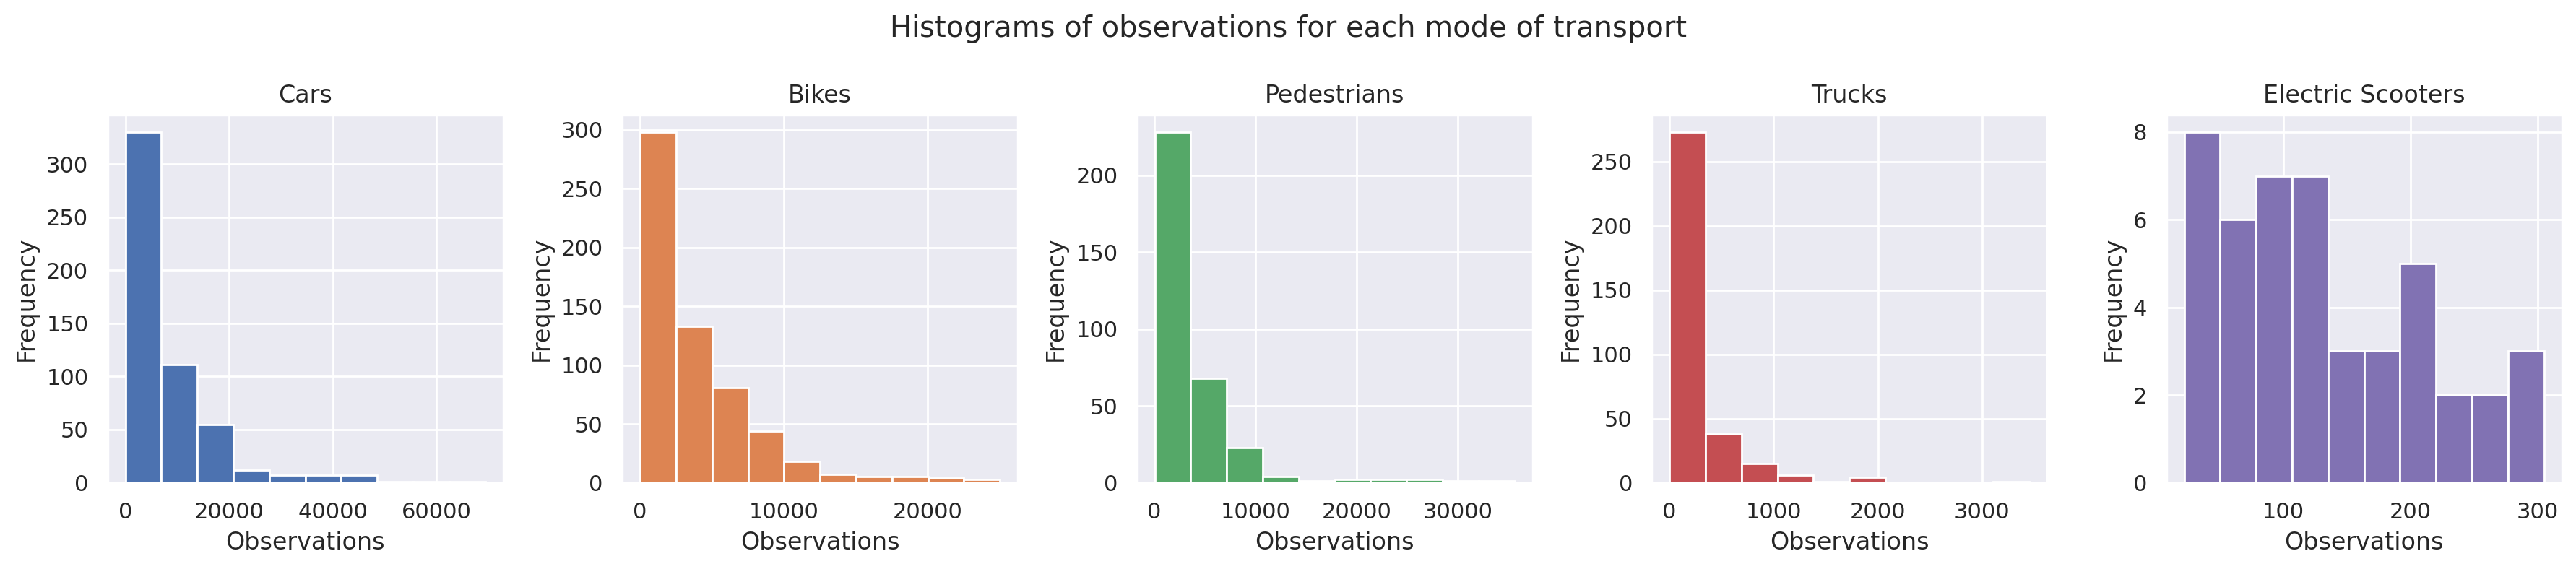

In [ ]:
palette = sns.color_palette()

fig, axes = plt.subplots(1,5, figsize=(18,4), dpi=200)
for i in range(len(modes_of_transport)):
    df_tt[[modes_of_transport[i]]].hist(ax=axes[i], color= palette[i])
    axes[i].set_xlabel("Observations")
    axes[i].set_ylabel("Frequency")
fig.suptitle('Histograms of observations for each mode of transport')
plt.tight_layout()
#plt.savefig('Histograms.png')
plt.show()

In [ ]:
# plot a map of Copenhagen
map_hooray = folium.Map(location=[55.676098, 12.568337],
                    zoom_start = 12,dpi=500)

# Plotting the points using folium's CircleMarker
# Loop over data, and include a couple extra information for each crime
for lng, lat in zip(df_tt.lon, df_tt.lat):
    folium.CircleMarker([lat, lng], radius=1.5,
                         fill=True
                         ).add_to(map_hooray)

# Show the map
map_hooray

## Time Data

In [ ]:
# Data preparation
df_traffic = pd.read_excel('data/SQL_2019.xlsx')
df_traffic

,TS,VEJNAVN,ÅR,DATO,RETNING,KATEGORI,ANTAL 6-7,ANTAL 7-8,ANTAL 8-9,ANTAL 9-10,ANTAL 10-11,ANTAL 11-12,ANTAL 12-13,ANTAL 13-14,ANTAL 14-15,ANTAL 15-16,ANTAL 16-17,ANTAL 17-18,ANTAL 18-19
0,117,FREDERIKSSUNDSVEJ øst for Frederiksborgvej,2002,507,FRA BYEN,PERSONBILER,153.0,415.0,495.0,364.0,441.0,493.0,561.0,523.0,564.0,746.0,694.0,630.0,NaN
1,117,FREDERIKSSUNDSVEJ øst for Frederiksborgvej,2002,507,FRA BYEN,MOTORCYKLER,7.0,15.0,12.0,15.0,6.0,11.0,9.0,7.0,14.0,29.0,37.0,22.0,NaN
2,117,FREDERIKSSUNDSVEJ øst for Frederiksborgvej,2002,507,FRA BYEN,"VAREVOGNE (MAX. 3,5 T)",43.0,68.0,68.0,104.0,110.0,142.0,102.0,123.0,115.0,170.0,87.0,61.0,NaN
3,117,FREDERIKSSUNDSVEJ øst for Frederiksborgvej,2002,507,FRA BYEN,A: LET TRAFIK IALT,203.0,498.0,575.0,483.0,557.0,646.0,672.0,653.0,693.0,945.0,818.0,713.0,NaN
4,117,FREDERIKSSUNDSVEJ øst for Frederiksborgvej,2002,507,FRA BYEN,"LASTBILER, 2 AKSLER",17.0,31.0,30.0,26.0,35.0,37.0,35.0,50.0,32.0,29.0,24.0,15.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148810,7635,VESTERBROGADE 3,2018,620,Mod sydvest (Vesterbro),Mænd,NaN,41.0,76.0,115.0,198.0,414.0,441.0,433.0,519.0,634.0,729.0,790.0,714.0
148811,7635,VESTERBROGADE 3,2018,620,Mod sydvest (Vesterbro),Børn under 12 år,NaN,0.0,0.0,10.0,11.0,37.0,57.0,40.0,70.0,40.0,66.0,38.0,42.0
148812,7635,VESTERBROGADE 3,2018,620,Mod sydvest (Vesterbro),Barnevogne,NaN,0.0,1.0,4.0,6.0,24.0,23.0,15.0,22.0,28.0,23.0,18.0,18.0
148813,7635,VESTERBROGADE 3,2018,620,Mod sydvest (Vesterbro),Løbere,NaN,3.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [ ]:
# Merge the two dataframes to get coordinates (t_nr and TS keys)
df_merged = df_traffic.merge(df_tt[['t_nr', 'wkb_geometry']], left_on='TS', right_on='t_nr', how='left')

In [ ]:
df_merged.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150187 entries, 0 to 150186
Data columns (total 21 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   TS            150187 non-null  int64  
 1   VEJNAVN       150187 non-null  object 
 2   ÅR            150187 non-null  int64  
 3   DATO          150187 non-null  int64  
 4   RETNING       150086 non-null  object 
 5   KATEGORI      150187 non-null  object 
 6   ANTAL 6-7     116881 non-null  float64
 7   ANTAL 7-8     149291 non-null  float64
 8   ANTAL 8-9     149291 non-null  float64
 9   ANTAL 9-10    149291 non-null  float64
 10  ANTAL 10-11   149291 non-null  float64
 11  ANTAL 11-12   149291 non-null  float64
 12  ANTAL 12-13   149291 non-null  float64
 13  ANTAL 13-14   149291 non-null  float64
 14  ANTAL 14-15   149291 non-null  float64
 15  ANTAL 15-16   149291 non-null  float64
 16  ANTAL 16-17   149291 non-null  float64
 17  ANTAL 17-18   149291 non-null  float64
 18  ANTA

In [ ]:
# Take values from 2009
df = df_merged[df_merged['ÅR'] >= 2009]

# Filter away nan values
df = df[~df['wkb_geometry'].isna()]

In [ ]:
df

,TS,VEJNAVN,ÅR,DATO,RETNING,KATEGORI,ANTAL 6-7,ANTAL 7-8,ANTAL 8-9,ANTAL 9-10,...,ANTAL 11-12,ANTAL 12-13,ANTAL 13-14,ANTAL 14-15,ANTAL 15-16,ANTAL 16-17,ANTAL 17-18,ANTAL 18-19,t_nr,wkb_geometry
19834,117,FREDERIKSSUNDSVEJ øst for Frederiksborgvej,2009,430,FRA BYEN,PERSONBILER,NaN,276.0,417.0,305.0,...,392.0,430.0,453.0,538.0,551.0,469.0,493.0,516.0,117.0,POINT (12.53403496752496 55.70169207674738)
19835,117,FREDERIKSSUNDSVEJ øst for Frederiksborgvej,2009,430,FRA BYEN,MOTORCYKLER,NaN,5.0,2.0,2.0,...,8.0,4.0,5.0,3.0,9.0,12.0,5.0,6.0,117.0,POINT (12.53403496752496 55.70169207674738)
19836,117,FREDERIKSSUNDSVEJ øst for Frederiksborgvej,2009,430,FRA BYEN,"VAREVOGNE (MAX. 3,5 T)",NaN,40.0,51.0,59.0,...,155.0,155.0,89.0,79.0,71.0,97.0,71.0,73.0,117.0,POINT (12.53403496752496 55.70169207674738)
19837,117,FREDERIKSSUNDSVEJ øst for Frederiksborgvej,2009,430,FRA BYEN,A: LET TRAFIK IALT,NaN,321.0,470.0,366.0,...,555.0,589.0,547.0,620.0,631.0,578.0,569.0,595.0,117.0,POINT (12.53403496752496 55.70169207674738)
19838,117,FREDERIKSSUNDSVEJ øst for Frederiksborgvej,2009,430,FRA BYEN,"SOLOLASTBILER, 2 AKSLER",NaN,17.0,21.0,18.0,...,7.0,6.0,15.0,16.0,11.0,4.0,2.0,2.0,117.0,POINT (12.53403496752496 55.70169207674738)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150182,7635,VESTERBROGADE 3,2018,620,Mod sydvest (Vesterbro),Mænd,NaN,41.0,76.0,115.0,...,414.0,441.0,433.0,519.0,634.0,729.0,790.0,714.0,7635.0,POINT (12.565946323498252 55.67490460097625)
150183,7635,VESTERBROGADE 3,2018,620,Mod sydvest (Vesterbro),Børn under 12 år,NaN,0.0,0.0,10.0,...,37.0,57.0,40.0,70.0,40.0,66.0,38.0,42.0,7635.0,POINT (12.565946323498252 55.67490460097625)
150184,7635,VESTERBROGADE 3,2018,620,Mod sydvest (Vesterbro),Barnevogne,NaN,0.0,1.0,4.0,...,24.0,23.0,15.0,22.0,28.0,23.0,18.0,18.0,7635.0,POINT (12.565946323498252 55.67490460097625)
150185,7635,VESTERBROGADE 3,2018,620,Mod sydvest (Vesterbro),Løbere,NaN,3.0,2.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,7635.0,POINT (12.565946323498252 55.67490460097625)


In [ ]:
df_filter = df[(df['KATEGORI'].str.lower() == 'personbiler') | (df['KATEGORI'].str.lower() == 'cykler + knallerter')]
df_filter

,TS,VEJNAVN,ÅR,DATO,RETNING,KATEGORI,ANTAL 6-7,ANTAL 7-8,ANTAL 8-9,ANTAL 9-10,...,ANTAL 11-12,ANTAL 12-13,ANTAL 13-14,ANTAL 14-15,ANTAL 15-16,ANTAL 16-17,ANTAL 17-18,ANTAL 18-19,t_nr,wkb_geometry
19834,117,FREDERIKSSUNDSVEJ øst for Frederiksborgvej,2009,430,FRA BYEN,PERSONBILER,NaN,276.0,417.0,305.0,...,392.0,430.0,453.0,538.0,551.0,469.0,493.0,516.0,117.0,POINT (12.53403496752496 55.70169207674738)
19846,117,FREDERIKSSUNDSVEJ øst for Frederiksborgvej,2009,430,FRA BYEN,CYKLER + KNALLERTER,NaN,345.0,492.0,264.0,...,250.0,260.0,262.0,425.0,621.0,847.0,751.0,580.0,117.0,POINT (12.53403496752496 55.70169207674738)
19848,117,FREDERIKSSUNDSVEJ øst for Frederiksborgvej,2009,430,MOD BYEN,PERSONBILER,NaN,327.0,535.0,397.0,...,441.0,464.0,457.0,536.0,517.0,618.0,636.0,456.0,117.0,POINT (12.53403496752496 55.70169207674738)
19860,117,FREDERIKSSUNDSVEJ øst for Frederiksborgvej,2009,430,MOD BYEN,CYKLER + KNALLERTER,NaN,355.0,883.0,553.0,...,355.0,347.0,295.0,379.0,507.0,541.0,499.0,358.0,117.0,POINT (12.53403496752496 55.70169207674738)
19872,122,GAMMEL KONGEVEJ 23 øst for Vordroffsvej,2009,903,MOD VEST,PERSONBILER,NaN,225.0,338.0,279.0,...,331.0,370.0,373.0,432.0,466.0,642.0,568.0,438.0,122.0,POINT (12.556001299281931 55.67382051591301)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149736,9865,LYNGBYVEJ n.f. Emdrupvej (lokalvej),2018,517,Mod syd (byen),CYKLER + KNALLERTER,NaN,639.0,884.0,184.0,...,77.0,100.0,121.0,187.0,381.0,380.0,347.0,194.0,9865.0,POINT (12.556999970376923 55.7190154010696)
149798,9889,JERNBANE ALLÉ 18 nv.f. Grøndals Parkvej,2018,529,Mod nordvest (Bogholder Allé),PERSONBILER,NaN,164.0,197.0,96.0,...,114.0,148.0,157.0,193.0,297.0,246.0,204.0,142.0,9889.0,POINT (12.49264558961257 55.68485527143219)
149810,9889,JERNBANE ALLÉ 18 nv.f. Grøndals Parkvej,2018,529,Mod nordvest (Bogholder Allé),CYKLER + KNALLERTER,NaN,160.0,135.0,82.0,...,73.0,90.0,152.0,204.0,346.0,353.0,225.0,164.0,9889.0,POINT (12.49264558961257 55.68485527143219)
149812,9889,JERNBANE ALLÉ 18 nv.f. Grøndals Parkvej,2018,529,Mod sydøst (Grøndals Parkvej),PERSONBILER,NaN,250.0,287.0,179.0,...,116.0,115.0,163.0,167.0,212.0,255.0,184.0,140.0,9889.0,POINT (12.49264558961257 55.68485527143219)


In [ ]:
df_filter.groupby('TS').size()

TS
1        32
9         2
12       32
13       40
14       40
         ..
10128     4
10131     4
10144     4
10145     4
10146     4
Length: 296, dtype: int64

In [ ]:
df[df.KATEGORI == 'CYKLER + KNALLERTER + LADCYKLER']

,TS,VEJNAVN,ÅR,DATO,RETNING,KATEGORI,ANTAL 6-7,ANTAL 7-8,ANTAL 8-9,ANTAL 9-10,...,ANTAL 11-12,ANTAL 12-13,ANTAL 13-14,ANTAL 14-15,ANTAL 15-16,ANTAL 16-17,ANTAL 17-18,ANTAL 18-19,t_nr,wkb_geometry
19847,117,FREDERIKSSUNDSVEJ øst for Frederiksborgvej,2009,430,FRA BYEN,CYKLER + KNALLERTER + LADCYKLER,NaN,346.0,496.0,265.0,...,252.0,262.0,262.0,425.0,623.0,855.0,756.0,585.0,117.0,POINT (12.53403496752496 55.70169207674738)
19861,117,FREDERIKSSUNDSVEJ øst for Frederiksborgvej,2009,430,MOD BYEN,CYKLER + KNALLERTER + LADCYKLER,NaN,358.0,888.0,561.0,...,361.0,350.0,299.0,388.0,515.0,545.0,502.0,361.0,117.0,POINT (12.53403496752496 55.70169207674738)
19885,122,GAMMEL KONGEVEJ 23 øst for Vordroffsvej,2009,903,MOD VEST,CYKLER + KNALLERTER + LADCYKLER,NaN,237.0,338.0,208.0,...,174.0,188.0,196.0,334.0,594.0,1060.0,799.0,508.0,122.0,POINT (12.556001299281931 55.67382051591301)
19899,122,GAMMEL KONGEVEJ 23 øst for Vordroffsvej,2009,903,MOD ØST,CYKLER + KNALLERTER + LADCYKLER,NaN,666.0,1358.0,547.0,...,240.0,225.0,165.0,326.0,400.0,504.0,422.0,388.0,122.0,POINT (12.556001299281931 55.67382051591301)
19913,123,GL. KØGE LANDEVEJ syd for Toftegårds Plads,2009,514,MOD NORD,CYKLER + KNALLERTER + LADCYKLER,NaN,231.0,267.0,99.0,...,85.0,77.0,88.0,64.0,131.0,152.0,130.0,92.0,123.0,POINT (12.514686665905312 55.65901039277438)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28766,902,VESTERBROGADE øst for Pile Allé,2011,505,MOD ØST (MOD BYEN),CYKLER + KNALLERTER + LADCYKLER,NaN,249.0,417.0,165.0,...,107.0,130.0,96.0,125.0,181.0,284.0,215.0,174.0,902.0,POINT (12.531984797933 55.6707659504385)
28780,903,PILE ALLÉ syd for Vesterbrogade,2011,505,MOD NORD,CYKLER + KNALLERTER + LADCYKLER,NaN,250.0,360.0,164.0,...,116.0,90.0,117.0,124.0,222.0,254.0,228.0,151.0,903.0,POINT (12.530974007175914 55.670324645536994)
28794,903,PILE ALLÉ syd for Vesterbrogade,2011,505,MOD SYD,CYKLER + KNALLERTER + LADCYKLER,NaN,208.0,283.0,171.0,...,85.0,117.0,106.0,147.0,228.0,325.0,269.0,177.0,903.0,POINT (12.530974007175914 55.670324645536994)
28808,904,GL. KONGEVEJ øst for Allégade,2011,505,MOD VEST (FRA BYEN),CYKLER + KNALLERTER + LADCYKLER,NaN,315.0,505.0,328.0,...,292.0,294.0,361.0,458.0,682.0,961.0,793.0,530.0,904.0,POINT (12.534451541696267 55.678043576241556)


In [ ]:
df[df.KATEGORI == 'CYKLER + KNALLERTER I ALT']

,TS,VEJNAVN,ÅR,DATO,RETNING,KATEGORI,ANTAL 6-7,ANTAL 7-8,ANTAL 8-9,ANTAL 9-10,...,ANTAL 11-12,ANTAL 12-13,ANTAL 13-14,ANTAL 14-15,ANTAL 15-16,ANTAL 16-17,ANTAL 17-18,ANTAL 18-19,t_nr,wkb_geometry
20684,27,KRISTEN BERNIKOWS GADE 2 ENSRETTET,2009,917,MOD SYD,CYKLER + KNALLERTER I ALT,NaN,298.0,978.0,515.0,...,352.0,463.0,415.0,609.0,820.0,912.0,844.0,556.0,27.0,POINT (12.582295655249021 55.67998567768585)
23140,127,GOTHERSGADE 2 vest for Kgs. Nytorv - ENSRETTET,2010,1005,MOD NORD (FRA BYEN),CYKLER + KNALLERTER I ALT,NaN,423.0,729.0,463.0,...,251.0,295.0,295.0,391.0,522.0,851.0,772.0,475.0,127.0,POINT (12.584855715162341 55.68156864607603)
23144,129,BRYGGEBROEN cykel- og gangbro,2010,921,MOD FISKETORVET,CYKLER + KNALLERTER I ALT,NaN,397.0,527.0,207.0,...,142.0,164.0,157.0,245.0,410.0,624.0,450.0,290.0,129.0,POINT (12.566332332461757 55.661678105791204)
23153,129,BRYGGEBROEN cykel- og gangbro,2010,921,MOD AMAGER,CYKLER + KNALLERTER I ALT,NaN,272.0,673.0,371.0,...,145.0,181.0,171.0,235.0,327.0,517.0,364.0,242.0,129.0,POINT (12.566332332461757 55.661678105791204)
23302,161,ÅBUEN cykel- og gangbro,2010,518,MOD SYD (MOD BYEN),CYKLER + KNALLERTER I ALT,NaN,188.0,381.0,160.0,...,80.0,79.0,70.0,127.0,253.0,239.0,152.0,136.0,161.0,POINT (12.545133225426333 55.68656014647919)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149693,975,VORDINGBORGGADE 89 v.f. Herninggade,2018,508,Mod vest (Strandboulevarden),CYKLER + KNALLERTER I ALT,NaN,42.0,42.0,38.0,...,39.0,50.0,63.0,133.0,258.0,317.0,287.0,167.0,975.0,POINT (12.587753952812452 55.708430608971284)
149723,9865,LYNGBYVEJ n.f. Emdrupvej (lokalvej),2018,517,Mod nord (fra byen),CYKLER + KNALLERTER I ALT,NaN,534.0,461.0,146.0,...,59.0,93.0,115.0,173.0,363.0,485.0,393.0,239.0,9865.0,POINT (12.556999970376923 55.7190154010696)
149737,9865,LYNGBYVEJ n.f. Emdrupvej (lokalvej),2018,517,Mod syd (byen),CYKLER + KNALLERTER I ALT,NaN,641.0,889.0,187.0,...,77.0,101.0,122.0,189.0,392.0,387.0,348.0,197.0,9865.0,POINT (12.556999970376923 55.7190154010696)
149811,9889,JERNBANE ALLÉ 18 nv.f. Grøndals Parkvej,2018,529,Mod nordvest (Bogholder Allé),CYKLER + KNALLERTER I ALT,NaN,161.0,141.0,88.0,...,74.0,94.0,157.0,207.0,354.0,359.0,231.0,170.0,9889.0,POINT (12.49264558961257 55.68485527143219)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=61ec0a5b-e327-402f-95c1-91c4aeb91c25' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>